# Get Box office data from moviemojo

In [32]:
# Imports
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import pickle
import matplotlib.pyplot as plt

## _Get the box office number for the desired week_

In [3]:
def get_site(week, year):
    """
    Get the page source for BOM top daily gross corresponding to month and year 
    """
    html = 'http://www.boxofficemojo.com/weekend/chart/?yr={}&wknd={}&p=.htm'.format(year, week)
    r = requests.get(html)  # Most sites can be accessed via the get function
    return r.content

## _Parse the source code and clean data_

In [4]:
def parse_source(page_source):
    
    page_soup = bs(page_source, "lxml")
    table = page_soup.find_all('table', attrs={'cellspacing': '1'})[0]  
    
    output_columns = ['TW', 'LW', 'Title', 'Studio', 'Weekend_Gross/$', '%_Change',
                  'Theater_Count','Theater_Change', 'Average/$', 'Total_Gross/$', 'Budget', 'num_week']
    output = dict((x, []) for x in output_columns)

    all_rows = table.find_all('tr')[1:106]

    for row in all_rows[:50]:
        row_cols = row.find_all('td')
        for dict_key, col in zip(output_columns, row_cols):
            output[dict_key].append(col.text)

    output_pd = pd.DataFrame(output)
    output_pd = output_pd[output_columns]
    
    return output_pd

def df_format(main_df):
    change_columns1 = ['Weekend_Gross/$', 'Average/$', 'Total_Gross/$', '%_Change']
    change_columns2 = ['Theater_Change', 'Theater_Count']
    change_columns3 = ['num_week', 'TW']
    main_df.drop('Budget', axis=1, inplace=True)
    for i in change_columns1:
        if i != '%_Change':
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].str.replace(',', '')
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].str.replace('$', '') 
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].astype(int) 
        else:
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].str.replace('%', '')
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].str.replace(',', '')
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].replace('-', 0)
            main_df.loc[:, str(i)] = main_df.loc[:, str(i)].astype(float) 

    for b in change_columns2:
        if b == 'Theater_Count':
            main_df.loc[:, str(b)] = main_df.loc[:, str(b)].str.replace(',', '')
            main_df.loc[:, str(b)] = main_df.loc[:, str(b)].astype(int)
        elif b == 'Theater_Change':
            main_df.loc[:, str(b)] = main_df.loc[:, str(b)].str.replace(',', '')
            main_df.loc[:, str(b)] = main_df.loc[:, str(b)].replace('-', 0)
            main_df.loc[:, str(b)] = main_df.loc[:, str(b)].astype(int) 

    for c in change_columns3:
        main_df.loc[:, str(c)] = main_df.loc[:, str(c)].astype(int) 
    main_df.set_index('TW', inplace=True)
    return main_df


def get_sum(df):
    print('total gross box office: ',df['Weekend_Gross/$'].sum(),'$')
    count = df['Theater_Count'].sort_values(ascending=False).head(10)
    print(count)

In [6]:
import datetime
datetime.date(2018, 10, 2).isocalendar()[1]

40

### _Get the table_

In [44]:
new = get_site(40, 2018)
main_df = parse_source(new)
main_df =df_format(main_df)
main_df

,LW,Title,Studio,Weekend_Gross/$,%_Change,Theater_Count,Theater_Change,Average/$,Total_Gross/$,num_week
TW,,,,,,,,,,
1,N,Venom (2018),Sony,80255756,0.0,4250,0,18884,80255756,1
2,N,A Star is Born (2018),WB,42908051,0.0,3686,0,11641,44258051,1
3,2,Smallfoot,WB,14402559,-37.5,4131,0,3486,42263504,2
4,1,Night School (2018),Uni.,12514925,-54.1,3019,9,4145,46991280,2
5,3,The House With A Clock In Its Walls,Uni.,7332665,-41.8,3463,-129,2117,55088925,3
6,4,A Simple Favor,LGF,3424954,-47.6,2408,-665,1422,49004310,4
7,5,The Nun,WB (NL),2703281,-50.2,2264,-1067,1194,113460591,5
8,7,Crazy Rich Asians,WB,2166626,-47.2,1466,-881,1478,169241568,8
9,6,Hell Fest,LGF,2083759,-59.4,2297,0,907,8873235,2


### _Further investigation_

In [8]:
# a closer investigation to see which studio is doing well
# week 36
week36 = pd.DataFrame(main_df.groupby('Studio')['Weekend_Gross/$'].sum()).sort_values('Weekend_Gross/$', ascending=False)
week36.head()

,Weekend_Gross/$
Studio,
Sony,80486133
WB,59763500
Uni.,19908490
LGF,5508713
WB (NL),2703281


- It seems like Warner Bros and Sony are doing prettey well in week 38 and 39

In [10]:
# Let's have a look week 35 and 34 
# To make this easier, let's create a function
def get_top_box_office(week, year):
    new = get_site(week, year)
    main_df = df_format(parse_source(new))
    return pd.DataFrame(main_df.groupby('Studio')['Weekend_Gross/$'].sum())\
                                .sort_values('Weekend_Gross/$', ascending=False)

In [13]:
week38 = get_top_box_office(38, 2018)
week39 = get_top_box_office(39, 2018)

In [14]:
week38.head()

,Weekend_Gross/$
Studio,
Uni.,27204165
LGF,10302574
WB (NL),9965635
Fox,9176459
WB,8707481


In [15]:
week39.head()

,Weekend_Gross/$
Studio,
Uni.,40105965
WB,28243825
LGF,11671629
WB (NL),5428875
Fox,3860826


- It seems like Warner Bros was doing pretty well in week34 and week35, too.

## Let's get all the top 10 box office from 2018 and combine them

In [16]:
# Modify the function and make it return the top 10 of studio name and weekend_gross

def get_top_box_office2(week, year):
    new = get_site(week, year)
    main_df = df_format(parse_source(new))
    main_df2 = pd.DataFrame(main_df.groupby('Studio')['Weekend_Gross/$'].sum())\
                                .sort_values('Weekend_Gross/$', ascending=False).reset_index()
    return main_df2['Studio'].tolist()[:10], main_df2['Weekend_Gross/$'].tolist()[:10]

In [17]:
%%time
data = []
for i in range(1, 40):
    studio, gross = get_top_box_office2(i, 2018)
    data.append((i, studio, gross))

CPU times: user 25.9 s, sys: 145 ms, total: 26 s
Wall time: 55.9 s


In [19]:
# Find all the top 10 studio in to a 1 list.
top_10 = []
for i in data:
    top_10.extend(i[1])

In [20]:
top_10_count = pd.DataFrame(pd.Series(top_10).value_counts()).reset_index()

In [21]:
top_10_count.columns = ['Studio', 'Counts']

In [22]:
top_10_count = top_10_count[:10]

In [23]:
top_10_count

,Studio,Counts
0,BV,37
1,WB,34
2,Uni.,32
3,Fox,31
4,Par.,27
5,Sony,25
6,STX,23
7,WB (NL),23
8,Focus,22
9,LGF,18


- It seems like BV (Disney) is the winner of 2018 box office so far, followed by Universal, Warner Brother, Fox, Paramount

In [24]:
# Let's caluculate the box office for each studio.
# What we need to do is to pair studio name and box office in one tuple
box_office = []
for a in data:
    for b, c in zip(a[1], a[2]):
        box_office.append((b, c))

In [25]:
box_office_df = pd.DataFrame(box_office, columns=['studio', 'box_office'])

In [26]:
# Get the sum of box office
box_office_sum = box_office_df.groupby('studio', as_index=False)['box_office'].sum().sort_values(by='box_office', ascending = False)

In [27]:
# Do some preprocessing, so we can join two table
box_office_sum_10 = box_office_sum[:10].reset_index()
box_office_sum_10['index'] = [i for i in range(len(box_office_sum_10))]

In [28]:
# Do some preprocessing, so we can join two table
top_10_count['index'] = [i for i in range(len(top_10_count))]

In [29]:
# join two dfs
top_10 = box_office_sum_10.set_index('index').join(top_10_count.set_index('index'))

In [30]:
# Now we can compare the top 10 box office number with top 10 studios are in top 10 box office every week
top_10

,studio,box_office,Studio,Counts
index,,,,
0,BV,1914547714,BV,37
1,Uni.,793989735,WB,34
2,WB,568380610,Uni.,32
3,Fox,552262928,Fox,31
4,Sony,447856779,Par.,27
5,Par.,383446438,Sony,25
6,WB (NL),281188082,STX,23
7,STX,169205092,WB (NL),23
8,LGF,148883908,Focus,22


## visualisation

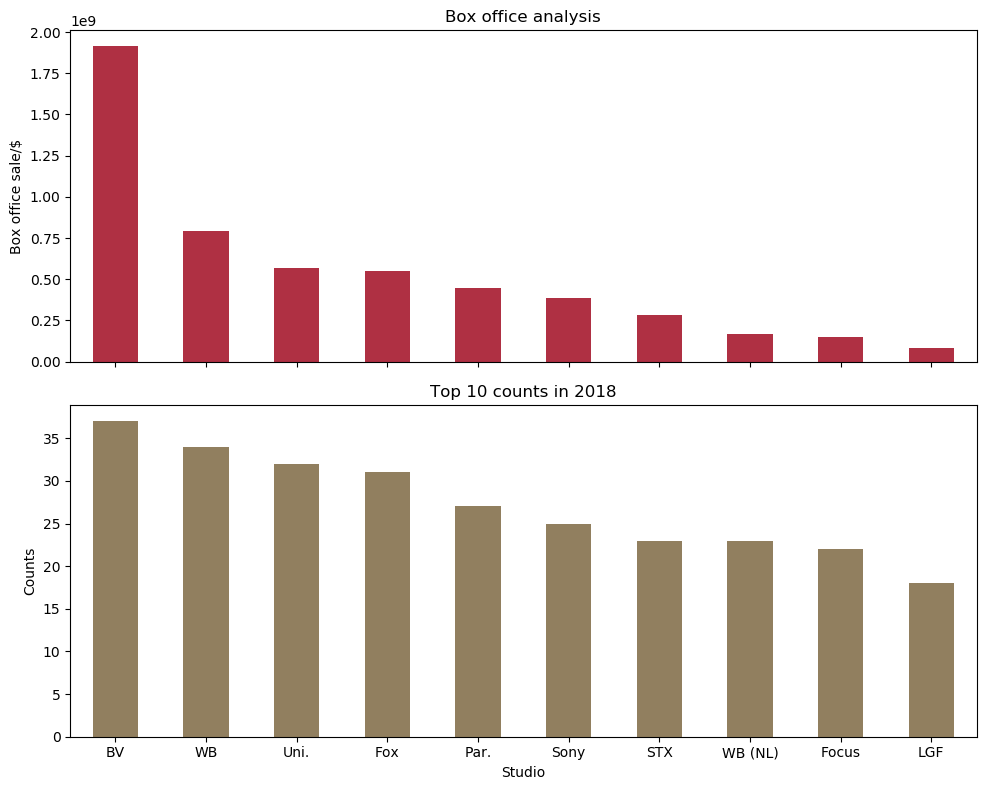

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), dpi = 100)

mycolors = ['#A6192E', '#85714D']
box_sale = top_10[['studio', 'box_office']].set_index('studio')
top_10counts = top_10[['Studio', 'Counts']].set_index('Studio')

f1 = box_sale.plot(kind='bar', alpha = 0.9, rot=0, color = mycolors[0], ax=ax[0], legend=False, sharex=True)
f2 = top_10counts.plot(kind='bar', alpha = 0.9, rot=0, color = mycolors[1], ax=ax[1], legend=False, sharex=True)

f1.set(title = "Box office analysis", xlabel='Studio', ylabel='Box office sale/$')
f2.set(title = "Top 10 counts in 2018", xlabel='Studio', ylabel='Counts')

fig.tight_layout()
 # Plot a Bar chart
plt.show()

- Two charts showed that once again BV (Disney donmintates the box office in 2018)
- BV's box office sale is more than twice as Universal, although it only got into top 10 weekend box offices 5 more times than Universal.
</br>
### This can be further explored in the next part

In [95]:
filename = 'movie_data.pkl'
moive = open(filename, 'wb')
pickle.dump(data, moive)
moive.close()

In [97]:
file = open(filename, 'rb')
data = pickle.load(file)
file.close()

In [100]:
len(data)

35